# A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.


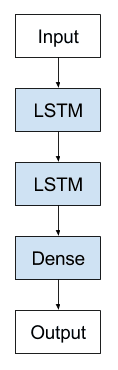

In [1]:
#1. import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
#2. read dataset
df=pd.read_csv('/content/raw.githubusercontent.com_mwitiderrick_stockprice_master_NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


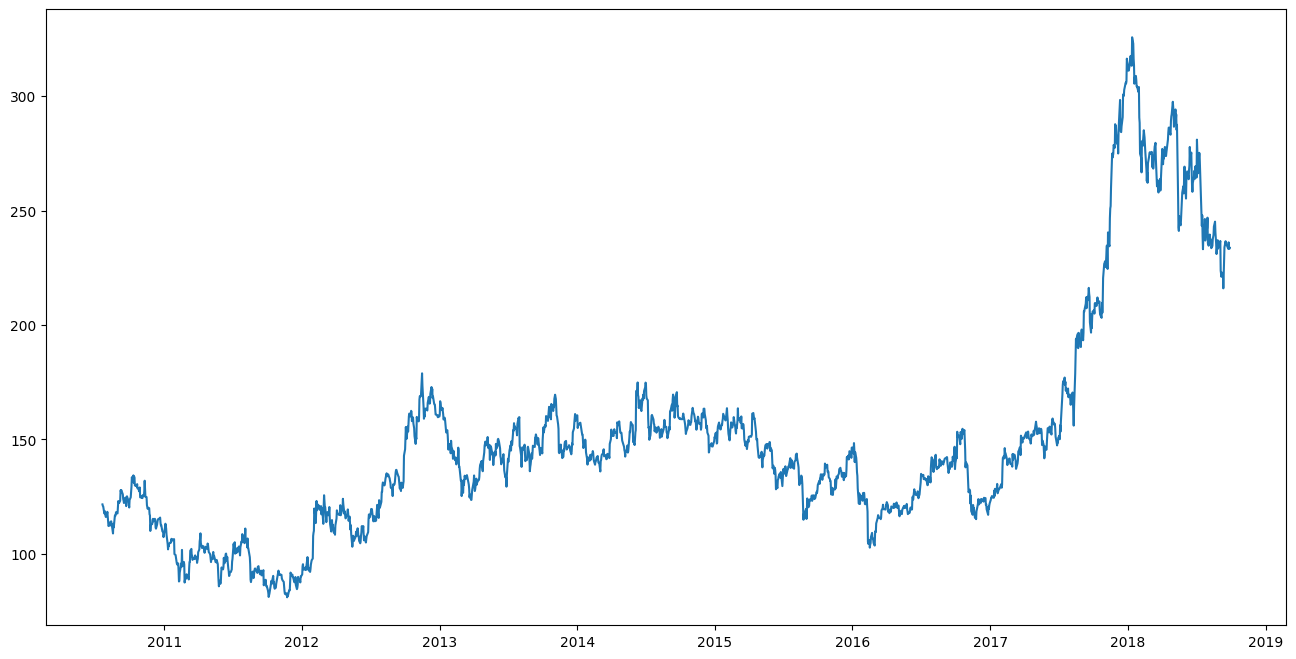

In [3]:
#3. Analyze the closing prices from dataframe
df["Date"] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"], label = 'Close Price History')

In [4]:
#4. Sort the dataset on date time and filter "Date" and "Close" columns
data = df.sort_index(ascending=True,axis=0)
new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0, len(data)):
  new_dataset["Date"][i] = data['Date'][i]
  new_dataset["Close"][i] = data['Close'][i]

In [5]:
#5. Normalize the new filtered dataset
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1)) #LSTM will easily handle our values
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


In [6]:
#6. Build and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [7]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

927/927 - 21s - loss: 9.7688e-04 - 21s/epoch - 22ms/step


In [8]:
#7. Take a sample of a dataset to make stock price predictions using the LSTM model
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

33/33 [==============================] - 1s 4ms/step


In [9]:
#8. Save the LSTM model
lstm_model.save("saved_lstm_model.h5")

<ipython-input-10-2aec890bc260>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


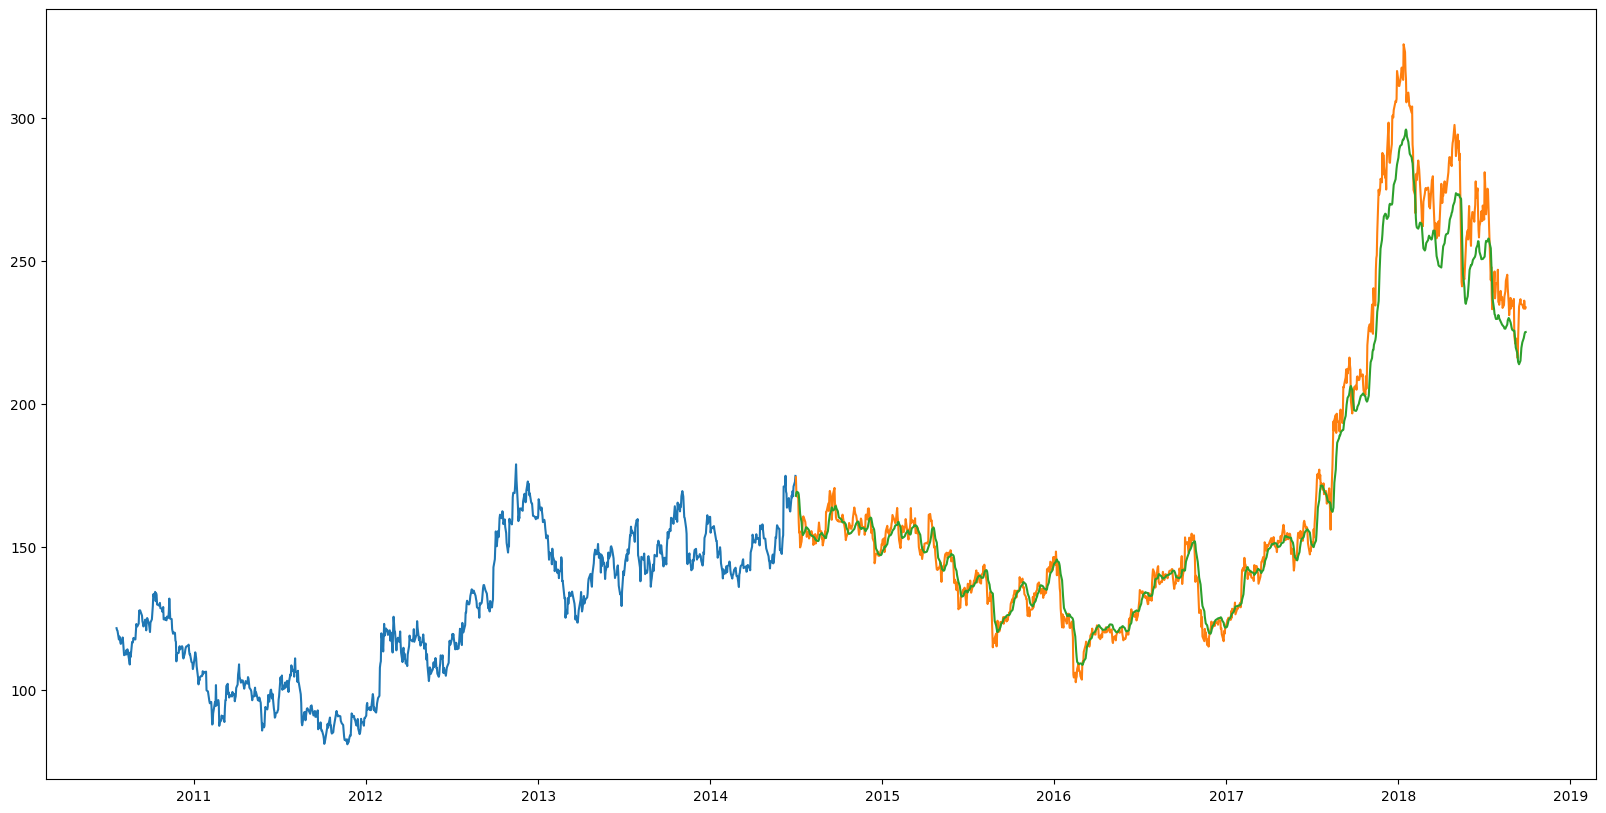

In [10]:
#9. Visualize the predicted stock costs with actual stock costs
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [11]:
### Orange and green line indicates that whatever we have predicted is similar to actual stock cost prices as they are overalapping each other